In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [2]:
df = pd.read_csv('train.csv')
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [4]:
df.drop('Segmentation', axis=1, inplace=True) # Not in test data

In [5]:
df.isna().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64

In [6]:
df['Ever_Married'].fillna(df['Ever_Married'].mode()[0], inplace=True)
df['Graduated'].fillna(df['Graduated'].mode()[0], inplace=True)
df['Profession'].fillna(df['Profession'].mode()[0], inplace=True)
df['Work_Experience'].fillna(df['Work_Experience'].mode()[0], inplace=True)
df['Family_Size'].fillna(df['Family_Size'].mode()[0], inplace=True)

In [7]:
# dropping the rows with missing target value
df = df[~df.Var_1.isna()]

In [8]:
df.Var_1.value_counts()/df.shape[0]

Cat_6    0.655405
Cat_4    0.136261
Cat_3    0.102853
Cat_2    0.052803
Cat_7    0.025400
Cat_1    0.016642
Cat_5    0.010636
Name: Var_1, dtype: float64

In [9]:
# using only 3 classes
df.Var_1 = df.Var_1.map({'Cat_6': 'Cat_6', 'Cat_4': 'Cat_4', 'Cat_3': 'Other', 'Cat_2': 'Other', 'Cat_7': 'Other', 'Cat_1': 'Other', 'Cat_5': 'Other'})
df.Var_1.value_counts()/df.shape[0]


Cat_6    0.655405
Other    0.208333
Cat_4    0.136261
Name: Var_1, dtype: float64

##### Shuffling of the data

In [10]:
df = df.sample(frac=1, random_state=17).reset_index(drop=True)
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,466551,Male,Yes,36,Yes,Artist,9.0,Average,2.0,Cat_6
1,467548,Male,Yes,48,Yes,Artist,0.0,High,2.0,Cat_6
2,460412,Female,No,31,No,Healthcare,0.0,Low,5.0,Other
3,460663,Female,No,33,No,Homemaker,9.0,Low,1.0,Cat_6
4,464301,Female,Yes,51,Yes,Doctor,0.0,Average,3.0,Cat_6


In [11]:
# creating validation set

from sklearn.model_selection import train_test_split

X = pd.get_dummies(df.drop(['ID', 'Var_1'], axis=1), drop_first=True)
y = df['Var_1']

y = y.map({'Cat_6': 2, 'Other': 0, 'Cat_4': 1})

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=17)

#### Designing and training a NN

In [12]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score, mean_squared_error
score_acc = make_scorer(accuracy_score)

In [14]:
import tensorflow as tf

In [15]:
import keras.backend as K

def f1_metric(y_true, y_pred): # weighted f1-score defined as custom metric for EarlyStopping monitoring
  
    def recall(y_true, y_pred):
        recalls = []
        for i in range(3):
          y_true_i = y_true[y_true==i]
          y_pred_i = y_pred[y_true==i]
          true_positives = K.sum(y_true_i[y_true_i==K.round(y_pred_i)])
          possible_positives = K.sum(y_true_i)
          recalls.append(true_positives.numpy() / (possible_positives.numpy() + K.epsilon()))
        return recalls
        
    def precision(y_true, y_pred):
        precisions = []
        for i in range(3):
          y_true_i = y_true[y_true==i]
          y_pred_i = y_pred[y_true==i]
          true_positives = K.sum(y_true_i[y_true_i==K.round(y_pred_i)])
          predicted_positives = K.sum(K.round(y_pred_i))
          precisions.append(true_positives.numpy() / (predicted_positives.numpy() + K.epsilon()))
        return(precisions)

    
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    f1s = []
    for i in range(3):
      f1s.append((2 * precisions[i] * recalls[i]) /(precisions[i] + recalls[i] + K.epsilon()) * len(y_true[y_true==i])/len(y_true)) # weighted F1 score

    return sum(f1s)

In [17]:
params_nn ={
    'neurons': ((12, 7), (15, 10)),
    'activation': ('relu', 'sigmoid'), #, 'softmax', 'exponential'),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 400),
    'epochs':(20, 40)
}

score_map = {}
for neurons in params_nn['neurons']:
    for activation in params_nn['activation']:
        for learning_rate in params_nn['learning_rate']:
            for batch_size in params_nn['batch_size']:
                for epochs in params_nn['epochs']:
                    neurons1 = neurons[0]
                    neurons2 = neurons[1]
                    def nn_cl_fun():
                        opt = Adam(learning_rate = learning_rate)
                        nn = Sequential()
                        nn.add(Dense(neurons1, input_shape=(16, ), activation=activation))
                        nn.add(Dense(neurons2, activation=activation))
                        nn.add(Dense(3, activation='softmax'))
                        nn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', f1_metric], run_eagerly=True)
                        return nn
                    es = EarlyStopping(monitor='val_f1_metric', mode='max', verbose=1, patience=5)
                    nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)
                    # kfold = KFold(n_splits=2, shuffle=True, random_state=17)
                    # score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}, error_score='raise').mean()
                    history = nn.fit(X_train, y_train, verbose=1, epochs=epochs, batch_size=batch_size, validation_data=(X_val, pd.get_dummies(y_val)), callbacks=[es])
                    val_acc = accuracy_score(nn.predict(X_val), y_val)
                    val_f1 = f1_score(nn.predict(X_val), y_val, average='weighted')
                    score_map[f"neurons: {neurons} || activation: {activation} || learning_rate: {learning_rate} || batch_size: {batch_size} || epochs: {epochs}"] = (val_acc, val_f1)
                    print(f"neurons: {neurons} || activation: {activation} || learning_rate: {learning_rate} || batch_size: {batch_size} || epochs: {epochs} || metrics: {(val_acc, val_f1)}")

Epoch 1/20
 1/32 [..............................] - ETA: 2s - loss: 2.9256 - accuracy: 0.6500 - f1_metric: 0.7879

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 72ms/step - loss: 1.1069 - accuracy: 0.5992 - f1_metric: 0.6434 - val_loss: 0.8594 - val_accuracy: 0.6760 - val_f1_metric: 0.7482
Epoch 2/20
32/32 [==============================] - 2s 69ms/step - loss: 0.8689 - accuracy: 0.6502 - f1_metric: 0.7352 - val_loss: 0.8301 - val_accuracy: 0.6754 - val_f1_metric: 0.7424
Epoch 3/20
32/32 [==============================] - 2s 78ms/step - loss: 0.8550 - accuracy: 0.6504 - f1_metric: 0.7248 - val_loss: 0.8250 - val_accuracy: 0.6748 - val_f1_metric: 0.7360
Epoch 4/20
32/32 [==============================] - 2s 69ms/step - loss: 0.8476 - accuracy: 0.6499 - f1_metric: 0.7262 - val_loss: 0.8248 - val_accuracy: 0.6735 - val_f1_metric: 0.7194
Epoch 5/20
32/32 [==============================] - 2s 69ms/step - loss: 0.8445 - accuracy: 0.6463 - f1_metric: 0.7222 - val_loss: 0.8165 - val_accuracy: 0.6685 - val_f1_metric: 0.7270
Epoch 6/20
32/32 [==============================] - 2s 70ms/step - loss: 0.8396 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 72ms/step - loss: 1.8648 - accuracy: 0.5603 - f1_metric: 0.6466 - val_loss: 0.8458 - val_accuracy: 0.6604 - val_f1_metric: 0.7273
Epoch 2/40
32/32 [==============================] - 2s 70ms/step - loss: 0.8599 - accuracy: 0.6448 - f1_metric: 0.7071 - val_loss: 0.8158 - val_accuracy: 0.6760 - val_f1_metric: 0.7301
Epoch 3/40
32/32 [==============================] - 2s 71ms/step - loss: 0.8349 - accuracy: 0.6521 - f1_metric: 0.7413 - val_loss: 0.8034 - val_accuracy: 0.6754 - val_f1_metric: 0.7542
Epoch 4/40
32/32 [==============================] - 2s 69ms/step - loss: 0.8314 - accuracy: 0.6531 - f1_metric: 0.7369 - val_loss: 0.8131 - val_accuracy: 0.6729 - val_f1_metric: 0.7219
Epoch 5/40
32/32 [==============================] - 2s 78ms/step - loss: 0.8342 - accuracy: 0.6559 - f1_metric: 0.7254 - val_loss: 0.8036 - val_accuracy: 0.6729 - val_f1_metric: 0.7361
Epoch 6/40
32/32 [==============================] - 2s 69ms/step - loss: 0.8279 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


16/16 [==============================] - 1s 77ms/step - loss: 1.9108 - accuracy: 0.3150 - f1_metric: 0.1580 - val_loss: 1.0270 - val_accuracy: 0.6767 - val_f1_metric: 0.0000e+00
Epoch 2/20
16/16 [==============================] - 1s 80ms/step - loss: 0.9890 - accuracy: 0.6509 - f1_metric: 0.1860 - val_loss: 0.8735 - val_accuracy: 0.6748 - val_f1_metric: 0.8050
Epoch 3/20
16/16 [==============================] - 1s 71ms/step - loss: 0.8838 - accuracy: 0.6506 - f1_metric: 0.7732 - val_loss: 0.8420 - val_accuracy: 0.6748 - val_f1_metric: 0.7854
Epoch 4/20
16/16 [==============================] - 1s 71ms/step - loss: 0.8568 - accuracy: 0.6506 - f1_metric: 0.7791 - val_loss: 0.8155 - val_accuracy: 0.6748 - val_f1_metric: 0.7992
Epoch 5/20
16/16 [==============================] - 1s 80ms/step - loss: 0.8493 - accuracy: 0.6506 - f1_metric: 0.7793 - val_loss: 0.8152 - val_accuracy: 0.6748 - val_f1_metric: 0.7896
Epoch 6/20
16/16 [==============================] - 1s 78ms/step - loss: 0.8439 - 

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


16/16 [==============================] - 1s 81ms/step - loss: 1.1986 - accuracy: 0.5708 - f1_metric: 0.6853 - val_loss: 0.8701 - val_accuracy: 0.6404 - val_f1_metric: 0.7296
Epoch 2/40
16/16 [==============================] - 1s 71ms/step - loss: 0.8765 - accuracy: 0.6463 - f1_metric: 0.7172 - val_loss: 0.8296 - val_accuracy: 0.6735 - val_f1_metric: 0.7558
Epoch 3/40
16/16 [==============================] - 1s 79ms/step - loss: 0.8476 - accuracy: 0.6496 - f1_metric: 0.7287 - val_loss: 0.8176 - val_accuracy: 0.6742 - val_f1_metric: 0.7286
Epoch 4/40
16/16 [==============================] - 1s 72ms/step - loss: 0.8365 - accuracy: 0.6507 - f1_metric: 0.7338 - val_loss: 0.8072 - val_accuracy: 0.6760 - val_f1_metric: 0.7424
Epoch 5/40
16/16 [==============================] - 1s 71ms/step - loss: 0.8336 - accuracy: 0.6513 - f1_metric: 0.7289 - val_loss: 0.8034 - val_accuracy: 0.6773 - val_f1_metric: 0.7550
Epoch 6/40
16/16 [==============================] - 1s 71ms/step - loss: 0.8301 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 71ms/step - loss: 4.6173 - accuracy: 0.5641 - f1_metric: 0.6196 - val_loss: 0.9935 - val_accuracy: 0.2020 - val_f1_metric: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 2s 78ms/step - loss: 0.9072 - accuracy: 0.6208 - f1_metric: 0.7147 - val_loss: 0.8516 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/20
32/32 [==============================] - 2s 71ms/step - loss: 0.8873 - accuracy: 0.6506 - f1_metric: 0.7879 - val_loss: 0.8522 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/20
32/32 [==============================] - 2s 78ms/step - loss: 0.8859 - accuracy: 0.6506 - f1_metric: 0.7880 - val_loss: 0.8490 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/20
32/32 [==============================] - 2s 77ms/step - loss: 0.8895 - accuracy: 0.6506 - f1_metric: 0.7879 - val_loss: 0.8490 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/20
32/32 [==============================] - 2s 77ms/step - loss: 0.8933 - 

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 70ms/step - loss: 2.9752 - accuracy: 0.6079 - f1_metric: 0.7106 - val_loss: 0.8779 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/40
32/32 [==============================] - 2s 69ms/step - loss: 0.8932 - accuracy: 0.6506 - f1_metric: 0.7877 - val_loss: 0.8485 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/40
32/32 [==============================] - 2s 70ms/step - loss: 0.8900 - accuracy: 0.6506 - f1_metric: 0.7879 - val_loss: 0.8574 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/40
32/32 [==============================] - 2s 70ms/step - loss: 0.8930 - accuracy: 0.6506 - f1_metric: 0.7622 - val_loss: 0.8624 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/40
32/32 [==============================] - 2s 77ms/step - loss: 0.8893 - accuracy: 0.6506 - f1_metric: 0.7879 - val_loss: 0.8505 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/40
32/32 [==============================] - 2s 70ms/step - loss: 0.8933 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


16/16 [==============================] - 1s 75ms/step - loss: 30.7192 - accuracy: 0.5949 - f1_metric: 0.7310 - val_loss: 0.8709 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/20
16/16 [==============================] - 1s 80ms/step - loss: 0.9035 - accuracy: 0.6506 - f1_metric: 0.7880 - val_loss: 0.8624 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/20
16/16 [==============================] - 1s 72ms/step - loss: 0.8910 - accuracy: 0.6506 - f1_metric: 0.7881 - val_loss: 0.8508 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/20
16/16 [==============================] - 1s 72ms/step - loss: 0.8855 - accuracy: 0.6506 - f1_metric: 0.7881 - val_loss: 0.8483 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/20
16/16 [==============================] - 1s 73ms/step - loss: 0.8853 - accuracy: 0.6506 - f1_metric: 0.7880 - val_loss: 0.8476 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/20
16/16 [==============================] - 1s 78ms/step - loss: 0.8831 - acc

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


16/16 [==============================] - 1s 75ms/step - loss: 34.2139 - accuracy: 0.4969 - f1_metric: 0.5530 - val_loss: 0.9720 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/40
16/16 [==============================] - 1s 72ms/step - loss: 0.9382 - accuracy: 0.6506 - f1_metric: 0.5901 - val_loss: 0.8582 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/40
16/16 [==============================] - 1s 69ms/step - loss: 0.8967 - accuracy: 0.6506 - f1_metric: 0.7881 - val_loss: 0.8468 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/40
16/16 [==============================] - 1s 71ms/step - loss: 0.8836 - accuracy: 0.6506 - f1_metric: 0.7881 - val_loss: 0.8513 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/40
16/16 [==============================] - 1s 71ms/step - loss: 0.8854 - accuracy: 0.6506 - f1_metric: 0.7879 - val_loss: 0.8484 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/40
16/16 [==============================] - 1s 72ms/step - loss: 0.8871 - acc

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 3s 79ms/step - loss: 0.9646 - accuracy: 0.5331 - f1_metric: 0.5900 - val_loss: 0.8442 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/20
32/32 [==============================] - 2s 78ms/step - loss: 0.8650 - accuracy: 0.6506 - f1_metric: 0.7879 - val_loss: 0.8257 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/20
32/32 [==============================] - 2s 70ms/step - loss: 0.8486 - accuracy: 0.6506 - f1_metric: 0.7813 - val_loss: 0.8170 - val_accuracy: 0.6748 - val_f1_metric: 0.7796
Epoch 4/20
32/32 [==============================] - 2s 78ms/step - loss: 0.8416 - accuracy: 0.6506 - f1_metric: 0.7351 - val_loss: 0.8125 - val_accuracy: 0.6748 - val_f1_metric: 0.7391
Epoch 5/20
32/32 [==============================] - 3s 79ms/step - loss: 0.8367 - accuracy: 0.6506 - f1_metric: 0.7257 - val_loss: 0.8085 - val_accuracy: 0.6748 - val_f1_metric: 0.7324
Epoch 6/20
32/32 [==============================] - 2s 70ms/step - loss: 0.8337 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 71ms/step - loss: 0.9032 - accuracy: 0.6495 - f1_metric: 0.6884 - val_loss: 0.8474 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/40
32/32 [==============================] - 2s 70ms/step - loss: 0.8761 - accuracy: 0.6506 - f1_metric: 0.7879 - val_loss: 0.8370 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/40
32/32 [==============================] - 2s 78ms/step - loss: 0.8597 - accuracy: 0.6506 - f1_metric: 0.7759 - val_loss: 0.8229 - val_accuracy: 0.6748 - val_f1_metric: 0.7991
Epoch 4/40
32/32 [==============================] - 2s 78ms/step - loss: 0.8477 - accuracy: 0.6506 - f1_metric: 0.7408 - val_loss: 0.8279 - val_accuracy: 0.6748 - val_f1_metric: 0.7062
Epoch 5/40
32/32 [==============================] - 2s 77ms/step - loss: 0.8374 - accuracy: 0.6506 - f1_metric: 0.7328 - val_loss: 0.8127 - val_accuracy: 0.6748 - val_f1_metric: 0.7313
Epoch 6/40
32/32 [==============================] - 2s 70ms/step - loss: 0.8343 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


16/16 [==============================] - 1s 76ms/step - loss: 0.9555 - accuracy: 0.5705 - f1_metric: 0.4436 - val_loss: 0.8516 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/20
16/16 [==============================] - 1s 80ms/step - loss: 0.8895 - accuracy: 0.6506 - f1_metric: 0.7881 - val_loss: 0.8476 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/20
16/16 [==============================] - 1s 94ms/step - loss: 0.8813 - accuracy: 0.6506 - f1_metric: 0.7882 - val_loss: 0.8490 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/20
16/16 [==============================] - 2s 103ms/step - loss: 0.8728 - accuracy: 0.6506 - f1_metric: 0.7880 - val_loss: 0.8374 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/20
16/16 [==============================] - 1s 79ms/step - loss: 0.8609 - accuracy: 0.6506 - f1_metric: 0.7881 - val_loss: 0.8281 - val_accuracy: 0.6748 - val_f1_metric: 0.8050
Epoch 6/20
16/16 [==============================] - 1s 71ms/step - loss: 0.8481 - acc

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


16/16 [==============================] - 1s 83ms/step - loss: 1.3592 - accuracy: 0.3272 - f1_metric: 0.2442 - val_loss: 0.8733 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/40
16/16 [==============================] - 1s 73ms/step - loss: 0.8895 - accuracy: 0.6506 - f1_metric: 0.7877 - val_loss: 0.8467 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/40
16/16 [==============================] - 1s 79ms/step - loss: 0.8838 - accuracy: 0.6506 - f1_metric: 0.7881 - val_loss: 0.8471 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/40
16/16 [==============================] - 1s 79ms/step - loss: 0.8810 - accuracy: 0.6506 - f1_metric: 0.7881 - val_loss: 0.8442 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/40
16/16 [==============================] - 1s 79ms/step - loss: 0.8788 - accuracy: 0.6506 - f1_metric: 0.7882 - val_loss: 0.8436 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/40
16/16 [==============================] - 1s 72ms/step - loss: 0.8768 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 3s 98ms/step - loss: 1.3831 - accuracy: 0.5342 - f1_metric: 0.6158 - val_loss: 0.8520 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/20
32/32 [==============================] - 2s 79ms/step - loss: 0.9090 - accuracy: 0.6506 - f1_metric: 0.7625 - val_loss: 0.8500 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/20
32/32 [==============================] - 2s 71ms/step - loss: 0.8951 - accuracy: 0.6506 - f1_metric: 0.7879 - val_loss: 0.8481 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/20
32/32 [==============================] - 2s 71ms/step - loss: 0.8971 - accuracy: 0.6506 - f1_metric: 0.7876 - val_loss: 0.8695 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/20
32/32 [==============================] - 2s 71ms/step - loss: 0.9002 - accuracy: 0.6506 - f1_metric: 0.7631 - val_loss: 0.8478 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/20
32/32 [==============================] - 2s 71ms/step - loss: 0.9144 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 72ms/step - loss: 1.0732 - accuracy: 0.6204 - f1_metric: 0.6485 - val_loss: 0.8542 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/40
32/32 [==============================] - 2s 78ms/step - loss: 0.8914 - accuracy: 0.6506 - f1_metric: 0.7877 - val_loss: 0.8499 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/40
32/32 [==============================] - 2s 79ms/step - loss: 0.8861 - accuracy: 0.6506 - f1_metric: 0.7877 - val_loss: 0.8481 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/40
32/32 [==============================] - 2s 69ms/step - loss: 0.8962 - accuracy: 0.6506 - f1_metric: 0.7877 - val_loss: 0.8653 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/40
32/32 [==============================] - 2s 78ms/step - loss: 0.8912 - accuracy: 0.6506 - f1_metric: 0.7878 - val_loss: 0.8504 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/40
32/32 [==============================] - 2s 78ms/step - loss: 0.8923 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


16/16 [==============================] - 1s 74ms/step - loss: 1.3395 - accuracy: 0.5636 - f1_metric: 0.5149 - val_loss: 0.8737 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/20
16/16 [==============================] - 1s 72ms/step - loss: 0.9063 - accuracy: 0.6506 - f1_metric: 0.7880 - val_loss: 0.8555 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/20
16/16 [==============================] - 1s 72ms/step - loss: 0.8922 - accuracy: 0.6506 - f1_metric: 0.7882 - val_loss: 0.8467 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/20
16/16 [==============================] - 1s 79ms/step - loss: 0.8871 - accuracy: 0.6506 - f1_metric: 0.7879 - val_loss: 0.8501 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/20
16/16 [==============================] - 1s 80ms/step - loss: 0.8932 - accuracy: 0.6506 - f1_metric: 0.7880 - val_loss: 0.8541 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/20
16/16 [==============================] - 1s 81ms/step - loss: 0.8864 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


16/16 [==============================] - 1s 74ms/step - loss: 1.3078 - accuracy: 0.5631 - f1_metric: 0.6989 - val_loss: 0.8663 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/40
16/16 [==============================] - 1s 73ms/step - loss: 0.9132 - accuracy: 0.6506 - f1_metric: 0.7881 - val_loss: 0.8803 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/40
16/16 [==============================] - 1s 71ms/step - loss: 0.8909 - accuracy: 0.6506 - f1_metric: 0.7882 - val_loss: 0.8586 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/40
16/16 [==============================] - 1s 80ms/step - loss: 0.8869 - accuracy: 0.6506 - f1_metric: 0.7881 - val_loss: 0.8568 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/40
16/16 [==============================] - 1s 72ms/step - loss: 0.8832 - accuracy: 0.6506 - f1_metric: 0.7882 - val_loss: 0.8516 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/40
16/16 [==============================] - 1s 70ms/step - loss: 0.8847 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 73ms/step - loss: 2.8349 - accuracy: 0.3901 - f1_metric: 0.1401 - val_loss: 0.9378 - val_accuracy: 0.6748 - val_f1_metric: 0.4036
Epoch 2/20
32/32 [==============================] - 3s 79ms/step - loss: 0.9166 - accuracy: 0.6506 - f1_metric: 0.6238 - val_loss: 0.8606 - val_accuracy: 0.6748 - val_f1_metric: 0.7226
Epoch 3/20
32/32 [==============================] - 2s 77ms/step - loss: 0.8788 - accuracy: 0.6506 - f1_metric: 0.7754 - val_loss: 0.8329 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/20
32/32 [==============================] - 2s 69ms/step - loss: 0.8612 - accuracy: 0.6506 - f1_metric: 0.7878 - val_loss: 0.8248 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/20
32/32 [==============================] - 2s 71ms/step - loss: 0.8521 - accuracy: 0.6506 - f1_metric: 0.7878 - val_loss: 0.8167 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/20
32/32 [==============================] - 2s 78ms/step - loss: 0.8489 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 71ms/step - loss: 1.7893 - accuracy: 0.5361 - f1_metric: 0.6371 - val_loss: 0.8764 - val_accuracy: 0.6417 - val_f1_metric: 0.7464
Epoch 2/40
32/32 [==============================] - 2s 79ms/step - loss: 0.8608 - accuracy: 0.6510 - f1_metric: 0.7484 - val_loss: 0.8241 - val_accuracy: 0.6760 - val_f1_metric: 0.7880
Epoch 3/40
32/32 [==============================] - 2s 70ms/step - loss: 0.8524 - accuracy: 0.6501 - f1_metric: 0.7446 - val_loss: 0.8199 - val_accuracy: 0.6735 - val_f1_metric: 0.7674
Epoch 4/40
32/32 [==============================] - 2s 70ms/step - loss: 0.8440 - accuracy: 0.6499 - f1_metric: 0.7369 - val_loss: 0.8318 - val_accuracy: 0.6742 - val_f1_metric: 0.7833
Epoch 5/40
32/32 [==============================] - 2s 69ms/step - loss: 0.8399 - accuracy: 0.6498 - f1_metric: 0.7380 - val_loss: 0.8216 - val_accuracy: 0.6710 - val_f1_metric: 0.7441
Epoch 6/40
32/32 [==============================] - 2s 78ms/step - loss: 0.8421 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


16/16 [==============================] - 1s 75ms/step - loss: 1.6124 - accuracy: 0.5842 - f1_metric: 0.7044 - val_loss: 1.0002 - val_accuracy: 0.4809 - val_f1_metric: 0.4467
Epoch 2/20
16/16 [==============================] - 1s 79ms/step - loss: 0.9174 - accuracy: 0.6025 - f1_metric: 0.6185 - val_loss: 0.8434 - val_accuracy: 0.6754 - val_f1_metric: 0.7997
Epoch 3/20
16/16 [==============================] - 1s 80ms/step - loss: 0.8662 - accuracy: 0.6510 - f1_metric: 0.7696 - val_loss: 0.8254 - val_accuracy: 0.6760 - val_f1_metric: 0.7707
Epoch 4/20
16/16 [==============================] - 1s 80ms/step - loss: 0.8542 - accuracy: 0.6517 - f1_metric: 0.7396 - val_loss: 0.8191 - val_accuracy: 0.6748 - val_f1_metric: 0.7823
Epoch 5/20
16/16 [==============================] - 1s 80ms/step - loss: 0.8495 - accuracy: 0.6518 - f1_metric: 0.7658 - val_loss: 0.8158 - val_accuracy: 0.6754 - val_f1_metric: 0.7888
Epoch 6/20
16/16 [==============================] - 1s 71ms/step - loss: 0.8455 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


16/16 [==============================] - 1s 81ms/step - loss: 0.9750 - accuracy: 0.6116 - f1_metric: 0.6849 - val_loss: 0.8443 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/40
16/16 [==============================] - 1s 79ms/step - loss: 0.8693 - accuracy: 0.6506 - f1_metric: 0.7408 - val_loss: 0.8261 - val_accuracy: 0.6748 - val_f1_metric: 0.7708
Epoch 3/40
16/16 [==============================] - 1s 73ms/step - loss: 0.8572 - accuracy: 0.6506 - f1_metric: 0.7383 - val_loss: 0.8290 - val_accuracy: 0.6748 - val_f1_metric: 0.7260
Epoch 4/40
16/16 [==============================] - 1s 79ms/step - loss: 0.8529 - accuracy: 0.6506 - f1_metric: 0.7350 - val_loss: 0.8207 - val_accuracy: 0.6748 - val_f1_metric: 0.7567
Epoch 5/40
16/16 [==============================] - 1s 78ms/step - loss: 0.8509 - accuracy: 0.6506 - f1_metric: 0.7326 - val_loss: 0.8205 - val_accuracy: 0.6748 - val_f1_metric: 0.7389
Epoch 6/40
16/16 [==============================] - 1s 72ms/step - loss: 0.8452 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 3s 79ms/step - loss: 11.8410 - accuracy: 0.6172 - f1_metric: 0.6559 - val_loss: 0.8619 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/20
32/32 [==============================] - 2s 78ms/step - loss: 0.8845 - accuracy: 0.6506 - f1_metric: 0.7877 - val_loss: 0.8465 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/20
32/32 [==============================] - 2s 70ms/step - loss: 0.8898 - accuracy: 0.6506 - f1_metric: 0.7875 - val_loss: 0.8650 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/20
32/32 [==============================] - 2s 79ms/step - loss: 0.8888 - accuracy: 0.6506 - f1_metric: 0.7877 - val_loss: 0.8498 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/20
32/32 [==============================] - 3s 79ms/step - loss: 0.8881 - accuracy: 0.6506 - f1_metric: 0.7878 - val_loss: 0.8506 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/20
32/32 [==============================] - 2s 78ms/step - loss: 0.8905 - acc

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 71ms/step - loss: 29.1194 - accuracy: 0.5007 - f1_metric: 0.5462 - val_loss: 0.9257 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/40
32/32 [==============================] - 2s 70ms/step - loss: 0.9093 - accuracy: 0.6506 - f1_metric: 0.7878 - val_loss: 0.8504 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/40
32/32 [==============================] - 2s 78ms/step - loss: 0.8860 - accuracy: 0.6506 - f1_metric: 0.7875 - val_loss: 0.8627 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/40
32/32 [==============================] - 3s 80ms/step - loss: 0.8880 - accuracy: 0.6506 - f1_metric: 0.7879 - val_loss: 0.8528 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/40
32/32 [==============================] - 2s 70ms/step - loss: 0.8891 - accuracy: 0.6506 - f1_metric: 0.7877 - val_loss: 0.8487 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/40
32/32 [==============================] - 2s 79ms/step - loss: 0.8884 - acc

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


16/16 [==============================] - 1s 83ms/step - loss: 10.7127 - accuracy: 0.5296 - f1_metric: 0.6012 - val_loss: 0.9727 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/20
16/16 [==============================] - 1s 70ms/step - loss: 0.9402 - accuracy: 0.6506 - f1_metric: 0.6909 - val_loss: 0.8751 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/20
16/16 [==============================] - 1s 72ms/step - loss: 0.8926 - accuracy: 0.6506 - f1_metric: 0.7881 - val_loss: 0.8543 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/20
16/16 [==============================] - 1s 80ms/step - loss: 0.8882 - accuracy: 0.6506 - f1_metric: 0.7879 - val_loss: 0.8532 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/20
16/16 [==============================] - 1s 80ms/step - loss: 0.8838 - accuracy: 0.6506 - f1_metric: 0.7881 - val_loss: 0.8606 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/20
16/16 [==============================] - 1s 73ms/step - loss: 0.8921 - acc

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


16/16 [==============================] - 1s 83ms/step - loss: 13.6937 - accuracy: 0.5309 - f1_metric: 0.6639 - val_loss: 0.9959 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/40
16/16 [==============================] - 1s 80ms/step - loss: 1.0253 - accuracy: 0.5137 - f1_metric: 0.5368 - val_loss: 0.9303 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/40
16/16 [==============================] - 1s 90ms/step - loss: 0.9164 - accuracy: 0.6506 - f1_metric: 0.6399 - val_loss: 0.8658 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/40
16/16 [==============================] - 2s 101ms/step - loss: 0.8887 - accuracy: 0.6506 - f1_metric: 0.7882 - val_loss: 0.8476 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/40
16/16 [==============================] - 1s 72ms/step - loss: 0.8836 - accuracy: 0.6506 - f1_metric: 0.7881 - val_loss: 0.8480 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/40
16/16 [==============================] - 1s 80ms/step - loss: 0.8876 - ac

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 71ms/step - loss: 0.8947 - accuracy: 0.6506 - f1_metric: 0.7380 - val_loss: 0.8454 - val_accuracy: 0.6748 - val_f1_metric: 0.7853
Epoch 2/20
32/32 [==============================] - 3s 79ms/step - loss: 0.8600 - accuracy: 0.6506 - f1_metric: 0.7650 - val_loss: 0.8246 - val_accuracy: 0.6748 - val_f1_metric: 0.7539
Epoch 3/20
32/32 [==============================] - 2s 69ms/step - loss: 0.8462 - accuracy: 0.6506 - f1_metric: 0.7358 - val_loss: 0.8264 - val_accuracy: 0.6754 - val_f1_metric: 0.6974
Epoch 4/20
32/32 [==============================] - 3s 79ms/step - loss: 0.8393 - accuracy: 0.6506 - f1_metric: 0.7171 - val_loss: 0.8086 - val_accuracy: 0.6748 - val_f1_metric: 0.7460
Epoch 5/20
32/32 [==============================] - 2s 78ms/step - loss: 0.8328 - accuracy: 0.6498 - f1_metric: 0.7203 - val_loss: 0.8050 - val_accuracy: 0.6748 - val_f1_metric: 0.7582
Epoch 6/20
32/32 [==============================] - 2s 71ms/step - loss: 0.8332 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 71ms/step - loss: 0.9225 - accuracy: 0.6506 - f1_metric: 0.7878 - val_loss: 0.8410 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/40
32/32 [==============================] - 2s 71ms/step - loss: 0.8641 - accuracy: 0.6506 - f1_metric: 0.7879 - val_loss: 0.8278 - val_accuracy: 0.6748 - val_f1_metric: 0.8040
Epoch 3/40
32/32 [==============================] - 2s 79ms/step - loss: 0.8469 - accuracy: 0.6506 - f1_metric: 0.7607 - val_loss: 0.8185 - val_accuracy: 0.6748 - val_f1_metric: 0.7391
Epoch 4/40
32/32 [==============================] - 2s 79ms/step - loss: 0.8393 - accuracy: 0.6506 - f1_metric: 0.7313 - val_loss: 0.8124 - val_accuracy: 0.6748 - val_f1_metric: 0.7176
Epoch 5/40
32/32 [==============================] - 2s 70ms/step - loss: 0.8384 - accuracy: 0.6506 - f1_metric: 0.7119 - val_loss: 0.8140 - val_accuracy: 0.6748 - val_f1_metric: 0.7082
Epoch 6/40
32/32 [==============================] - 2s 71ms/step - loss: 0.8320 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


16/16 [==============================] - 1s 74ms/step - loss: 1.1239 - accuracy: 0.4231 - f1_metric: 0.2996 - val_loss: 0.8706 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/20
16/16 [==============================] - 1s 72ms/step - loss: 0.8889 - accuracy: 0.6506 - f1_metric: 0.7881 - val_loss: 0.8465 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/20
16/16 [==============================] - 1s 80ms/step - loss: 0.8837 - accuracy: 0.6506 - f1_metric: 0.7880 - val_loss: 0.8464 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/20
16/16 [==============================] - 1s 81ms/step - loss: 0.8809 - accuracy: 0.6506 - f1_metric: 0.7881 - val_loss: 0.8465 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/20
16/16 [==============================] - 1s 79ms/step - loss: 0.8793 - accuracy: 0.6506 - f1_metric: 0.7882 - val_loss: 0.8448 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/20
16/16 [==============================] - 1s 72ms/step - loss: 0.8773 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


16/16 [==============================] - 1s 83ms/step - loss: 0.8976 - accuracy: 0.6506 - f1_metric: 0.6894 - val_loss: 0.8425 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/40
16/16 [==============================] - 1s 74ms/step - loss: 0.8752 - accuracy: 0.6506 - f1_metric: 0.7878 - val_loss: 0.8319 - val_accuracy: 0.6748 - val_f1_metric: 0.8050
Epoch 3/40
16/16 [==============================] - 1s 80ms/step - loss: 0.8584 - accuracy: 0.6506 - f1_metric: 0.7748 - val_loss: 0.8244 - val_accuracy: 0.6748 - val_f1_metric: 0.7646
Epoch 4/40
16/16 [==============================] - 1s 81ms/step - loss: 0.8480 - accuracy: 0.6506 - f1_metric: 0.7427 - val_loss: 0.8159 - val_accuracy: 0.6748 - val_f1_metric: 0.7561
Epoch 5/40
16/16 [==============================] - 1s 71ms/step - loss: 0.8399 - accuracy: 0.6507 - f1_metric: 0.7232 - val_loss: 0.8126 - val_accuracy: 0.6748 - val_f1_metric: 0.7453
Epoch 6/40
16/16 [==============================] - 1s 79ms/step - loss: 0.8368 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 3s 80ms/step - loss: 1.6634 - accuracy: 0.4940 - f1_metric: 0.5865 - val_loss: 0.9010 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/20
32/32 [==============================] - 2s 70ms/step - loss: 0.9357 - accuracy: 0.6204 - f1_metric: 0.6418 - val_loss: 0.8743 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/20
32/32 [==============================] - 2s 70ms/step - loss: 0.8992 - accuracy: 0.6506 - f1_metric: 0.7628 - val_loss: 0.8493 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/20
32/32 [==============================] - 3s 79ms/step - loss: 0.8907 - accuracy: 0.6506 - f1_metric: 0.7880 - val_loss: 0.8469 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/20
32/32 [==============================] - 2s 78ms/step - loss: 0.8919 - accuracy: 0.6506 - f1_metric: 0.7880 - val_loss: 0.8567 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/20
32/32 [==============================] - 2s 71ms/step - loss: 0.8988 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 71ms/step - loss: 1.4593 - accuracy: 0.5594 - f1_metric: 0.5743 - val_loss: 0.8960 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/40
32/32 [==============================] - 2s 78ms/step - loss: 0.9019 - accuracy: 0.6506 - f1_metric: 0.7879 - val_loss: 0.8524 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/40
32/32 [==============================] - 2s 78ms/step - loss: 0.8990 - accuracy: 0.6506 - f1_metric: 0.7622 - val_loss: 0.8502 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/40
32/32 [==============================] - 2s 69ms/step - loss: 0.8991 - accuracy: 0.6506 - f1_metric: 0.7880 - val_loss: 0.8656 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/40
32/32 [==============================] - 2s 70ms/step - loss: 0.9246 - accuracy: 0.6506 - f1_metric: 0.6645 - val_loss: 0.8493 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/40
32/32 [==============================] - 2s 79ms/step - loss: 0.9131 - accu

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


16/16 [==============================] - 1s 75ms/step - loss: 2.4512 - accuracy: 0.5081 - f1_metric: 0.6410 - val_loss: 1.4356 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/20
16/16 [==============================] - 1s 71ms/step - loss: 1.2127 - accuracy: 0.5830 - f1_metric: 0.6680 - val_loss: 1.1010 - val_accuracy: 0.1232 - val_f1_metric: 0.0000e+00
Epoch 3/20
16/16 [==============================] - 1s 72ms/step - loss: 0.9806 - accuracy: 0.5870 - f1_metric: 0.6897 - val_loss: 0.9078 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/20
16/16 [==============================] - 1s 72ms/step - loss: 0.9197 - accuracy: 0.6506 - f1_metric: 0.7881 - val_loss: 0.8489 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/20
16/16 [==============================] - 1s 72ms/step - loss: 0.9041 - accuracy: 0.6506 - f1_metric: 0.7880 - val_loss: 0.8895 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/20
16/16 [==============================] - 1s 80ms/step - loss: 0.9155 - 

<ipython-input-17-556339c31167>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


16/16 [==============================] - 1s 76ms/step - loss: 1.3646 - accuracy: 0.5827 - f1_metric: 0.6699 - val_loss: 0.8669 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 2/40
16/16 [==============================] - 1s 73ms/step - loss: 0.8883 - accuracy: 0.6506 - f1_metric: 0.7882 - val_loss: 0.8473 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 3/40
16/16 [==============================] - 1s 72ms/step - loss: 0.8845 - accuracy: 0.6506 - f1_metric: 0.7881 - val_loss: 0.8491 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 4/40
16/16 [==============================] - 1s 71ms/step - loss: 0.8874 - accuracy: 0.6506 - f1_metric: 0.7879 - val_loss: 0.8581 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 5/40
16/16 [==============================] - 1s 80ms/step - loss: 0.8861 - accuracy: 0.6506 - f1_metric: 0.7881 - val_loss: 0.8528 - val_accuracy: 0.6748 - val_f1_metric: 0.8054
Epoch 6/40
16/16 [==============================] - 1s 72ms/step - loss: 0.8872 - accu

In [18]:
sorted(score_map.items(), key=lambda item: item[1][-1])[-5:] # top performing architectures (based on validation f1-score)

[('neurons: (15, 10) || activation: sigmoid || learning_rate: 0.01 || batch_size: 400 || epochs: 40',
  (0.6747967479674797, 0.8058252427184466)),
 ('neurons: (15, 10) || activation: sigmoid || learning_rate: 1 || batch_size: 200 || epochs: 20',
  (0.6747967479674797, 0.8058252427184466)),
 ('neurons: (15, 10) || activation: sigmoid || learning_rate: 1 || batch_size: 200 || epochs: 40',
  (0.6747967479674797, 0.8058252427184466)),
 ('neurons: (15, 10) || activation: sigmoid || learning_rate: 1 || batch_size: 400 || epochs: 20',
  (0.6747967479674797, 0.8058252427184466)),
 ('neurons: (15, 10) || activation: sigmoid || learning_rate: 1 || batch_size: 400 || epochs: 40',
  (0.6747967479674797, 0.8058252427184466))]

**Best Hyperparameters**

* Hidden layer 1: #nodes = 15
* Hidden layer 2: #nodes = 10
* Activation functions for the hidden layers: sigmoid
* Learning rate: 1
* Batch size: 400
* Num. of epochs: 40 with early stopping at epoch 7.


Since this was the last model trained on the above cell, we can go head with the predictions with the model nn.

#### Reporting the performance on Test data 

In [19]:
test = pd.read_csv('test.csv')
test.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


In [20]:
test.isna().sum()

ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
dtype: int64

In [21]:
test['Ever_Married'].fillna(test['Ever_Married'].mode()[0], inplace=True)
test['Graduated'].fillna(test['Graduated'].mode()[0], inplace=True)
test['Profession'].fillna(test['Profession'].mode()[0], inplace=True)
test['Work_Experience'].fillna(test['Work_Experience'].mode()[0], inplace=True)
test['Family_Size'].fillna(test['Family_Size'].mode()[0], inplace=True)

test = test[~test.Var_1.isna()]
test['Var_1'] = test['Var_1'].map({'Cat_6': 'Cat_6', 'Cat_4': 'Cat_4', 'Cat_3': 'Other', 'Cat_2': 'Other', 'Cat_7': 'Other', 'Cat_1': 'Other', 'Cat_5': 'Other'})
test.Var_1.value_counts()/test.shape[0]

<ipython-input-21-dccbfeca7087>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Var_1'] = test['Var_1'].map({'Cat_6': 'Cat_6', 'Cat_4': 'Cat_4', 'Cat_3': 'Other', 'Cat_2': 'Other', 'Cat_7': 'Other', 'Cat_1': 'Other', 'Cat_5': 'Other'})


Cat_6    0.644316
Other    0.206936
Cat_4    0.148748
Name: Var_1, dtype: float64

In [22]:
X_test = pd.get_dummies(test.drop(['ID', 'Var_1'], axis=1), drop_first=True)
y_test = test['Var_1']
y_test = y_test.map({'Cat_6': 2, 'Other': 0, 'Cat_4': 1})

In [23]:
y_pred = nn.predict(X_test)

82/82 [==============================] - 0s 3ms/step


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

print("Accuracy: ", round(accuracy_score(y_test, y_pred), 3), end=';     ')
print("Classification Error: ", round(1-accuracy_score(y_test, y_pred), 3))
# the scores for each class
print("Classwise precision: ", precision_score(y_test, y_pred, average=None, zero_division=0)) 
# calculated for each label and a support-weighted mean is taken
print("Weighted precision: ", round(precision_score(y_test, y_pred, average='weighted', zero_division=0), 3))
# calculated for each label and an unweighted mean is taken
print("Macro precision: ", round(precision_score(y_test, y_pred, average='macro', zero_division=0), 3))
# calculated globally by counting the total TPs, FNs and FPs
print("Micro precision: ", round(precision_score(y_test, y_pred, average='micro', zero_division=0), 3))
# the scores for each class
print("Classwise recall: ", recall_score(y_test, y_pred, average=None)) 
# calculated for each label and an unweighted mean is taken
print("Macro recall: ", round(recall_score(y_test, y_pred, average='macro'), 3))
# calculated globally by counting the total TPs, FNs and FPs
print("Micro recall: ", round(recall_score(y_test, y_pred, average='micro'), 3))

# calculated for each label and an unweighted mean is taken
print("Macro f1 score: ", round(f1_score(y_test, y_pred, average='macro'), 3))
# calculated globally by counting the total TPs, FNs and FPs
print("Micro f1 score: ", round(f1_score(y_test, y_pred, average='micro'), 3))
# calculated for each label and a support-weighted mean is taken
print("Weighted f1 score: ", round(f1_score(y_test, y_pred, average='weighted'), 3))


Accuracy:  0.644;     Classification Error:  0.356
Classwise precision:  [0.         0.         0.64431599]
Weighted precision:  0.415
Macro precision:  0.215
Micro precision:  0.644
Classwise recall:  [0. 0. 1.]
Macro recall:  0.333
Micro recall:  0.644
Macro f1 score:  0.261
Micro f1 score:  0.644
Weighted f1 score:  0.505


#### **Significance of the above metrics**


* Accuracy: This metric gives the total % of correct predictions made by the model.
* Classification Error: This is the complement of accuracy (1- accuracy); gives the total % of incorrect predictions made.
* Precision: This signifies of the total positive predictions made by the model, how many were actually positive. In case of multiclass, we have classwise precision values as well as aggregates. Aggregates are described below using 'micro', 'macro' & 'weighted'.
* Recall: This signifies of the total positive samples, how many were actually predicted as positive. In case of multiclass, we have classwise precision values as well as aggregates. Aggregates are described below using 'micro', 'macro' & 'weighted'.
* F1 score: This signifies a traded off value between precision and recall. In case of multiclass, we have aggregates. Aggregates are described below using 'micro', 'macro' & 'weighted'.

- Macro: Macro precision, recall & f1 scores are those that are calculated for each label and an unweighted mean is taken
- Micro: Macro precision, recall & f1 scores are those that are calculated globally by counting the total TPs, FNs and FPs
- Weighted: Macro precision, recall & f1 scores are those that arecalculated for each label and a support-weighted mean is taken

In the above case, the unweighted based metrics, macro~, are extremely poor when compared to the other probably because of the class imbalance in the data.



#### Loss & f1-score for training & validation sets

In [25]:
import matplotlib.pyplot as plt

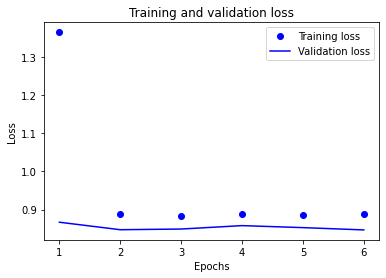

In [26]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

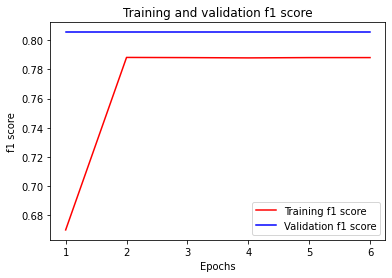

In [27]:
history_dict = history.history

loss_values = history_dict['f1_metric']
val_loss_values = history_dict['val_f1_metric']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'r', label='Training f1 score')
plt.plot(epochs, val_loss_values, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
plt.xlabel('Epochs')
plt.ylabel('f1 score')
plt.legend()

plt.show()

#### ROC-AUC curve

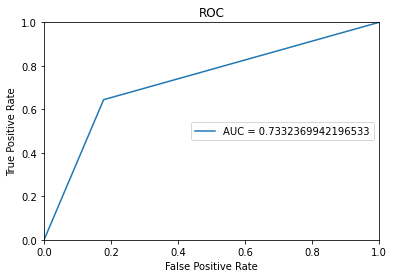

<Figure size 1080x720 with 0 Axes>

In [28]:
# Code taken from: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
# This code binarises the 3 class (Eg. Class 0 --> [0, 0, 0]; Class 1 --> [0, 1, 0], ...) and then graphs the roc.

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve

# Binarize data for getting AUC 
y_test_bin = label_binarize(y_test, classes=range(3)) 
y_pred_bin = label_binarize(y_pred, classes=range(3))

# Calculate FP , TP rate
fpr, tpr, threshold = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())

# Get AUC , 
auc = roc_auc_score(y_test_bin, y_pred_bin, average='micro', multi_class='ovr')
 
#create ROC curve
plt.plot(fpr,tpr , label= f"AUC = {auc}" , )
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0]) 
plt.title('ROC')
plt.legend(loc=7)
plt.figure(figsize = [15, 10])

plt.show()

Here, our AUC ~ 0.7. Generally, AUC~0.55 implies no discriminative power while anything above 0.5 is acceptable behaviour. From the above metrics, we know that, the model predicts class 2 (Cat_6) alone, and hence this AUC. An ideal threshold for the model would be at (TPR, FPR) = ~(0.65, 0.17) (the point closest to the top left corner of your ROC space). The threshold used to generate this point seems like the ideal one. Anyhow, this is not a good model as it has low predictive accuracy over other classes.

#### Data sampling

Here, I am trying to upsample the minority classes using SMOTE (https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).

<ipython-input-29-f8844da636ce>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_xticklabels(['Other', 'Cat_4', 'Cat_6'])


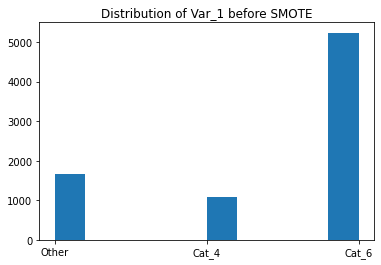

In [29]:
plt.hist(y)
plt.xticks([0,1,2])
plt.axes().set_xticklabels(['Other', 'Cat_4', 'Cat_6'])
plt.title('Distribution of Var_1 before SMOTE')
plt.show()

In [30]:
# oversampling using SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

<ipython-input-31-cdaff140fdb1>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_xticklabels(['Other', 'Cat_4', 'Cat_6'])


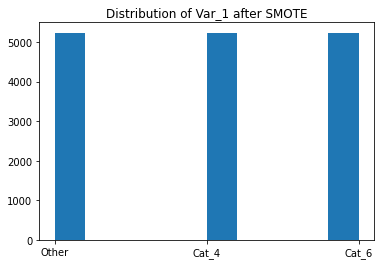

In [31]:
plt.hist(y)
plt.xticks([0,1,2])
plt.axes().set_xticklabels(['Other', 'Cat_4', 'Cat_6'])
plt.title('Distribution of Var_1 after SMOTE')
plt.show()

#### Performing train-validation split, NN design & training, model tuning with early stopping on validation set

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=17)

params_nn ={
    'neurons': ((12, 7), (15, 10)),
    'activation': ('relu', 'sigmoid'), #, 'softmax', 'exponential'),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 400),
    'epochs':(20, 40)
}

score_map = {}
for neurons in params_nn['neurons']:
    for activation in params_nn['activation']:
        for learning_rate in params_nn['learning_rate']:
            for batch_size in params_nn['batch_size']:
                for epochs in params_nn['epochs']:
                    neurons1 = neurons[0]
                    neurons2 = neurons[1]
                    def nn_cl_fun():
                        opt = Adam(learning_rate = learning_rate)
                        nn = Sequential()
                        nn.add(Dense(neurons1, input_shape=(16, ), activation=activation))
                        nn.add(Dense(neurons2, activation=activation))
                        nn.add(Dense(3, activation='softmax'))
                        nn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', f1_metric], run_eagerly=True)
                        return nn
                    es = EarlyStopping(monitor='val_f1_metric', mode='max', verbose=1, patience=5)
                    nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)
                    # kfold = KFold(n_splits=2, shuffle=True, random_state=17)
                    # score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}, error_score='raise').mean()
                    history = nn.fit(X_train, y_train, verbose=1, epochs=epochs, batch_size=batch_size, validation_data=(X_val, pd.get_dummies(y_val)), callbacks=[es])
                    val_acc = accuracy_score(nn.predict(X_val), y_val)
                    val_f1 = f1_score(nn.predict(X_val), y_val, average='weighted')
                    score_map[f"neurons: {neurons} || activation: {activation} || learning_rate: {learning_rate} || batch_size: {batch_size} || epochs: {epochs}"] = (val_acc, val_f1)
                    print(f"neurons: {neurons} || activation: {activation} || learning_rate: {learning_rate} || batch_size: {batch_size} || epochs: {epochs} || metrics: {(val_acc, val_f1)}")


sorted(score_map.items(), key=lambda item: item[1][-1])[-5:] # top performing architectures (based on validation f1-score)

Epoch 1/20
 1/63 [..............................] - ETA: 4s - loss: 5.4997 - accuracy: 0.3000 - f1_metric: 0.4615

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


63/63 [==============================] - 5s 81ms/step - loss: 1.3209 - accuracy: 0.3593 - f1_metric: 0.2023 - val_loss: 1.0508 - val_accuracy: 0.4407 - val_f1_metric: 0.0948
Epoch 2/20
63/63 [==============================] - 5s 78ms/step - loss: 1.0326 - accuracy: 0.4405 - f1_metric: 0.1308 - val_loss: 1.0147 - val_accuracy: 0.4696 - val_f1_metric: 0.2015
Epoch 3/20
63/63 [==============================] - 4s 71ms/step - loss: 1.0081 - accuracy: 0.4726 - f1_metric: 0.2168 - val_loss: 0.9954 - val_accuracy: 0.4909 - val_f1_metric: 0.3034
Epoch 4/20
63/63 [==============================] - 5s 78ms/step - loss: 0.9903 - accuracy: 0.4871 - f1_metric: 0.3171 - val_loss: 0.9865 - val_accuracy: 0.4909 - val_f1_metric: 0.3277
Epoch 5/20
63/63 [==============================] - 4s 69ms/step - loss: 0.9871 - accuracy: 0.4906 - f1_metric: 0.3717 - val_loss: 0.9754 - val_accuracy: 0.5046 - val_f1_metric: 0.3949
Epoch 6/20
63/63 [==============================] - 5s 79ms/step - loss: 0.9783 - accu

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


63/63 [==============================] - 6s 90ms/step - loss: 1.1636 - accuracy: 0.3961 - f1_metric: 0.2788 - val_loss: 1.0615 - val_accuracy: 0.4123 - val_f1_metric: 0.2892
Epoch 2/40
63/63 [==============================] - 4s 71ms/step - loss: 1.0155 - accuracy: 0.4556 - f1_metric: 0.2924 - val_loss: 0.9948 - val_accuracy: 0.4820 - val_f1_metric: 0.3583
Epoch 3/40
63/63 [==============================] - 4s 71ms/step - loss: 0.9939 - accuracy: 0.4860 - f1_metric: 0.3684 - val_loss: 0.9849 - val_accuracy: 0.5014 - val_f1_metric: 0.4420
Epoch 4/40
63/63 [==============================] - 4s 70ms/step - loss: 0.9785 - accuracy: 0.4954 - f1_metric: 0.4019 - val_loss: 1.0189 - val_accuracy: 0.4836 - val_f1_metric: 0.3696
Epoch 5/40
63/63 [==============================] - 4s 71ms/step - loss: 0.9843 - accuracy: 0.5004 - f1_metric: 0.4084 - val_loss: 0.9808 - val_accuracy: 0.4804 - val_f1_metric: 0.4561
Epoch 6/40
63/63 [==============================] - 4s 70ms/step - loss: 0.9715 - accu

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 3s 81ms/step - loss: 1.2587 - accuracy: 0.3751 - f1_metric: 0.2832 - val_loss: 1.0962 - val_accuracy: 0.4057 - val_f1_metric: 0.0952
Epoch 2/20
32/32 [==============================] - 3s 79ms/step - loss: 1.0803 - accuracy: 0.4223 - f1_metric: 0.0683 - val_loss: 1.0654 - val_accuracy: 0.4426 - val_f1_metric: 0.0467
Epoch 3/20
32/32 [==============================] - 2s 71ms/step - loss: 1.0581 - accuracy: 0.4481 - f1_metric: 0.0952 - val_loss: 1.0568 - val_accuracy: 0.4353 - val_f1_metric: 0.1398
Epoch 4/20
32/32 [==============================] - 2s 73ms/step - loss: 1.0457 - accuracy: 0.4574 - f1_metric: 0.1749 - val_loss: 1.0397 - val_accuracy: 0.4668 - val_f1_metric: 0.2540
Epoch 5/20
32/32 [==============================] - 2s 72ms/step - loss: 1.0316 - accuracy: 0.4653 - f1_metric: 0.2507 - val_loss: 1.0198 - val_accuracy: 0.4795 - val_f1_metric: 0.3263
Epoch 6/20
32/32 [==============================] - 2s 73ms/step - loss: 1.0059 - accu

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 3s 81ms/step - loss: 1.3992 - accuracy: 0.3518 - f1_metric: 0.3307 - val_loss: 1.0752 - val_accuracy: 0.4066 - val_f1_metric: 0.2238
Epoch 2/40
32/32 [==============================] - 2s 78ms/step - loss: 1.0579 - accuracy: 0.4203 - f1_metric: 0.1535 - val_loss: 1.0380 - val_accuracy: 0.4184 - val_f1_metric: 0.1767
Epoch 3/40
32/32 [==============================] - 2s 77ms/step - loss: 1.0235 - accuracy: 0.4666 - f1_metric: 0.1944 - val_loss: 1.0209 - val_accuracy: 0.4645 - val_f1_metric: 0.2904
Epoch 4/40
32/32 [==============================] - 2s 72ms/step - loss: 1.0040 - accuracy: 0.4899 - f1_metric: 0.2679 - val_loss: 1.0070 - val_accuracy: 0.4636 - val_f1_metric: 0.2606
Epoch 5/40
32/32 [==============================] - 2s 72ms/step - loss: 0.9894 - accuracy: 0.4970 - f1_metric: 0.3173 - val_loss: 0.9811 - val_accuracy: 0.5062 - val_f1_metric: 0.3587
Epoch 6/40
32/32 [==============================] - 2s 72ms/step - loss: 0.9763 - accu

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


63/63 [==============================] - 5s 72ms/step - loss: 8.5365 - accuracy: 0.3333 - f1_metric: 0.1106 - val_loss: 1.1015 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 2/20
63/63 [==============================] - 4s 71ms/step - loss: 1.1042 - accuracy: 0.3370 - f1_metric: 0.0000e+00 - val_loss: 1.1090 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 3/20
63/63 [==============================] - 4s 72ms/step - loss: 1.1092 - accuracy: 0.3334 - f1_metric: 0.0000e+00 - val_loss: 1.1075 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 4/20
63/63 [==============================] - 5s 80ms/step - loss: 1.1058 - accuracy: 0.3335 - f1_metric: 0.0000e+00 - val_loss: 1.1368 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 5/20
63/63 [==============================] - 4s 71ms/step - loss: 1.1115 - accuracy: 0.3331 - f1_metric: 0.0000e+00 - val_loss: 1.1021 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 6/20
63/63 [==============================] 

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


63/63 [==============================] - 5s 81ms/step - loss: 10.1939 - accuracy: 0.3337 - f1_metric: 0.1459 - val_loss: 1.1111 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 2/40
63/63 [==============================] - 5s 79ms/step - loss: 1.1134 - accuracy: 0.3246 - f1_metric: 0.0000e+00 - val_loss: 1.1087 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 3/40
63/63 [==============================] - 5s 72ms/step - loss: 1.1051 - accuracy: 0.3278 - f1_metric: 0.0000e+00 - val_loss: 1.0986 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 4/40
63/63 [==============================] - 5s 72ms/step - loss: 1.1053 - accuracy: 0.3371 - f1_metric: 0.0000e+00 - val_loss: 1.1074 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 5/40
63/63 [==============================] - 5s 81ms/step - loss: 1.1037 - accuracy: 0.3335 - f1_metric: 0.0000e+00 - val_loss: 1.1118 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 6/40
63/63 [==============================]

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 75ms/step - loss: 5.7076 - accuracy: 0.3290 - f1_metric: 0.2146 - val_loss: 1.1073 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 3s 80ms/step - loss: 1.1110 - accuracy: 0.3290 - f1_metric: 0.0000e+00 - val_loss: 1.1007 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 2s 72ms/step - loss: 1.1021 - accuracy: 0.3270 - f1_metric: 0.0000e+00 - val_loss: 1.0991 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 3s 79ms/step - loss: 1.1035 - accuracy: 0.3304 - f1_metric: 0.0000e+00 - val_loss: 1.0995 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 2s 72ms/step - loss: 1.1014 - accuracy: 0.3272 - f1_metric: 0.0000e+00 - val_loss: 1.1048 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 6/20
32/32 [==============================] 

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 3s 82ms/step - loss: 19.2390 - accuracy: 0.3331 - f1_metric: 0.1737 - val_loss: 1.1050 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 2/40
32/32 [==============================] - 3s 80ms/step - loss: 1.1023 - accuracy: 0.3324 - f1_metric: 0.0000e+00 - val_loss: 1.1034 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 3/40
32/32 [==============================] - 2s 73ms/step - loss: 1.1058 - accuracy: 0.3313 - f1_metric: 0.0000e+00 - val_loss: 1.1003 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 4/40
32/32 [==============================] - 2s 72ms/step - loss: 1.1067 - accuracy: 0.3291 - f1_metric: 0.0000e+00 - val_loss: 1.1022 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 5/40
32/32 [==============================] - 3s 80ms/step - loss: 1.1073 - accuracy: 0.3303 - f1_metric: 0.0000e+00 - val_loss: 1.1019 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 6/40
32/32 [==============================]

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


63/63 [==============================] - 5s 80ms/step - loss: 1.0873 - accuracy: 0.3819 - f1_metric: 0.0011 - val_loss: 1.0521 - val_accuracy: 0.4445 - val_f1_metric: 0.0222
Epoch 2/20
63/63 [==============================] - 5s 80ms/step - loss: 1.0266 - accuracy: 0.4617 - f1_metric: 0.2323 - val_loss: 1.0008 - val_accuracy: 0.4913 - val_f1_metric: 0.3751
Epoch 3/20
63/63 [==============================] - 5s 73ms/step - loss: 0.9914 - accuracy: 0.4895 - f1_metric: 0.3994 - val_loss: 0.9828 - val_accuracy: 0.4983 - val_f1_metric: 0.4418
Epoch 4/20
63/63 [==============================] - 5s 84ms/step - loss: 0.9781 - accuracy: 0.5016 - f1_metric: 0.4345 - val_loss: 0.9776 - val_accuracy: 0.5040 - val_f1_metric: 0.4258
Epoch 5/20
63/63 [==============================] - 5s 78ms/step - loss: 0.9762 - accuracy: 0.5035 - f1_metric: 0.4308 - val_loss: 0.9747 - val_accuracy: 0.4913 - val_f1_metric: 0.4708
Epoch 6/20
63/63 [==============================] - 4s 71ms/step - loss: 0.9687 - accu

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


63/63 [==============================] - 5s 72ms/step - loss: 1.0837 - accuracy: 0.3854 - f1_metric: 0.0034 - val_loss: 1.0523 - val_accuracy: 0.4499 - val_f1_metric: 0.0691
Epoch 2/40
63/63 [==============================] - 4s 70ms/step - loss: 1.0220 - accuracy: 0.4665 - f1_metric: 0.2091 - val_loss: 0.9914 - val_accuracy: 0.4884 - val_f1_metric: 0.3849
Epoch 3/40
63/63 [==============================] - 4s 70ms/step - loss: 0.9824 - accuracy: 0.4973 - f1_metric: 0.4075 - val_loss: 0.9808 - val_accuracy: 0.5040 - val_f1_metric: 0.3970
Epoch 4/40
63/63 [==============================] - 4s 71ms/step - loss: 0.9707 - accuracy: 0.5097 - f1_metric: 0.4339 - val_loss: 0.9813 - val_accuracy: 0.5046 - val_f1_metric: 0.3717
Epoch 5/40
63/63 [==============================] - 4s 70ms/step - loss: 0.9632 - accuracy: 0.5176 - f1_metric: 0.4438 - val_loss: 0.9687 - val_accuracy: 0.5192 - val_f1_metric: 0.4845
Epoch 6/40
63/63 [==============================] - 5s 80ms/step - loss: 0.9600 - accu

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 3s 81ms/step - loss: 1.1026 - accuracy: 0.3528 - f1_metric: 0.0156 - val_loss: 1.0855 - val_accuracy: 0.4047 - val_f1_metric: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 2s 71ms/step - loss: 1.0734 - accuracy: 0.4313 - f1_metric: 0.0000e+00 - val_loss: 1.0523 - val_accuracy: 0.4448 - val_f1_metric: 0.0014
Epoch 3/20
32/32 [==============================] - 2s 71ms/step - loss: 1.0368 - accuracy: 0.4589 - f1_metric: 0.1487 - val_loss: 1.0287 - val_accuracy: 0.4639 - val_f1_metric: 0.3398
Epoch 4/20
32/32 [==============================] - 2s 71ms/step - loss: 1.0030 - accuracy: 0.4866 - f1_metric: 0.3408 - val_loss: 0.9870 - val_accuracy: 0.4989 - val_f1_metric: 0.4220
Epoch 5/20
32/32 [==============================] - 2s 71ms/step - loss: 0.9781 - accuracy: 0.5042 - f1_metric: 0.4151 - val_loss: 0.9763 - val_accuracy: 0.5075 - val_f1_metric: 0.4095
Epoch 6/20
32/32 [==============================] - 3s 80ms/step - loss: 0.969

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 3s 83ms/step - loss: 1.0906 - accuracy: 0.3816 - f1_metric: 0.0000e+00 - val_loss: 1.0803 - val_accuracy: 0.4092 - val_f1_metric: 0.0000e+00
Epoch 2/40
32/32 [==============================] - 2s 73ms/step - loss: 1.0612 - accuracy: 0.4288 - f1_metric: 0.0105 - val_loss: 1.0377 - val_accuracy: 0.4518 - val_f1_metric: 0.1048
Epoch 3/40
32/32 [==============================] - 2s 73ms/step - loss: 1.0189 - accuracy: 0.4719 - f1_metric: 0.2416 - val_loss: 1.0027 - val_accuracy: 0.4890 - val_f1_metric: 0.3863
Epoch 4/40
32/32 [==============================] - 2s 73ms/step - loss: 0.9931 - accuracy: 0.4872 - f1_metric: 0.3986 - val_loss: 0.9831 - val_accuracy: 0.4916 - val_f1_metric: 0.4274
Epoch 5/40
32/32 [==============================] - 3s 92ms/step - loss: 0.9755 - accuracy: 0.5028 - f1_metric: 0.4237 - val_loss: 0.9787 - val_accuracy: 0.5065 - val_f1_metric: 0.4851
Epoch 6/40
32/32 [==============================] - 3s 79ms/step - loss: 0.968

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


63/63 [==============================] - 5s 72ms/step - loss: 1.1396 - accuracy: 0.3297 - f1_metric: 0.0462 - val_loss: 1.1028 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 2/20
63/63 [==============================] - 5s 72ms/step - loss: 1.1049 - accuracy: 0.3364 - f1_metric: 0.0000e+00 - val_loss: 1.1116 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 3/20
63/63 [==============================] - 5s 72ms/step - loss: 1.1116 - accuracy: 0.3348 - f1_metric: 0.0000e+00 - val_loss: 1.1155 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 4/20
63/63 [==============================] - 5s 72ms/step - loss: 1.1084 - accuracy: 0.3292 - f1_metric: 0.0000e+00 - val_loss: 1.1150 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 5/20
63/63 [==============================] - 5s 72ms/step - loss: 1.1126 - accuracy: 0.3321 - f1_metric: 0.0000e+00 - val_loss: 1.1006 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 6/20
63/63 [==============================] 

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


63/63 [==============================] - 5s 73ms/step - loss: 1.1924 - accuracy: 0.3378 - f1_metric: 0.0895 - val_loss: 1.1079 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 2/40
63/63 [==============================] - 5s 79ms/step - loss: 1.1192 - accuracy: 0.3276 - f1_metric: 0.0153 - val_loss: 1.1266 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 3/40
63/63 [==============================] - 5s 80ms/step - loss: 1.1065 - accuracy: 0.3374 - f1_metric: 0.0000e+00 - val_loss: 1.1001 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 4/40
63/63 [==============================] - 5s 79ms/step - loss: 1.1090 - accuracy: 0.3331 - f1_metric: 0.0000e+00 - val_loss: 1.1075 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 5/40
63/63 [==============================] - 4s 71ms/step - loss: 1.1109 - accuracy: 0.3353 - f1_metric: 0.0000e+00 - val_loss: 1.1121 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 6/40
63/63 [==============================] - 5s

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 75ms/step - loss: 1.3173 - accuracy: 0.3265 - f1_metric: 0.2017 - val_loss: 1.1085 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 3s 80ms/step - loss: 1.1130 - accuracy: 0.3341 - f1_metric: 0.0000e+00 - val_loss: 1.0998 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 2s 74ms/step - loss: 1.1064 - accuracy: 0.3302 - f1_metric: 0.0000e+00 - val_loss: 1.0991 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 2s 74ms/step - loss: 1.1034 - accuracy: 0.3247 - f1_metric: 0.0000e+00 - val_loss: 1.1035 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 2s 73ms/step - loss: 1.1024 - accuracy: 0.3327 - f1_metric: 0.0000e+00 - val_loss: 1.1128 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 6/20
32/32 [==============================] 

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 73ms/step - loss: 1.3684 - accuracy: 0.3315 - f1_metric: 0.1396 - val_loss: 1.1143 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 2/40
32/32 [==============================] - 3s 80ms/step - loss: 1.1042 - accuracy: 0.3371 - f1_metric: 0.0000e+00 - val_loss: 1.1059 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 3/40
32/32 [==============================] - 2s 72ms/step - loss: 1.1024 - accuracy: 0.3411 - f1_metric: 0.0000e+00 - val_loss: 1.1019 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 4/40
32/32 [==============================] - 2s 74ms/step - loss: 1.1057 - accuracy: 0.3327 - f1_metric: 0.0000e+00 - val_loss: 1.1100 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 5/40
32/32 [==============================] - 3s 81ms/step - loss: 1.1078 - accuracy: 0.3336 - f1_metric: 0.0000e+00 - val_loss: 1.1016 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 6/40
32/32 [==============================] 

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


63/63 [==============================] - 5s 72ms/step - loss: 1.1635 - accuracy: 0.3596 - f1_metric: 0.1191 - val_loss: 1.0697 - val_accuracy: 0.3996 - val_f1_metric: 0.0948
Epoch 2/20
63/63 [==============================] - 5s 80ms/step - loss: 1.0570 - accuracy: 0.4109 - f1_metric: 0.1086 - val_loss: 1.0461 - val_accuracy: 0.4117 - val_f1_metric: 0.2011
Epoch 3/20
63/63 [==============================] - 4s 71ms/step - loss: 1.0293 - accuracy: 0.4276 - f1_metric: 0.1625 - val_loss: 1.0060 - val_accuracy: 0.4699 - val_f1_metric: 0.1909
Epoch 4/20
63/63 [==============================] - 5s 72ms/step - loss: 0.9935 - accuracy: 0.4927 - f1_metric: 0.2869 - val_loss: 0.9891 - val_accuracy: 0.5005 - val_f1_metric: 0.3251
Epoch 5/20
63/63 [==============================] - 5s 80ms/step - loss: 0.9853 - accuracy: 0.4969 - f1_metric: 0.3991 - val_loss: 0.9779 - val_accuracy: 0.5119 - val_f1_metric: 0.4018
Epoch 6/20
63/63 [==============================] - 5s 80ms/step - loss: 0.9745 - accu

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


63/63 [==============================] - 5s 80ms/step - loss: 1.3490 - accuracy: 0.3905 - f1_metric: 0.2285 - val_loss: 1.0267 - val_accuracy: 0.4620 - val_f1_metric: 0.0961
Epoch 2/40
63/63 [==============================] - 4s 70ms/step - loss: 1.0009 - accuracy: 0.4856 - f1_metric: 0.2890 - val_loss: 0.9892 - val_accuracy: 0.4941 - val_f1_metric: 0.3233
Epoch 3/40
63/63 [==============================] - 5s 79ms/step - loss: 0.9815 - accuracy: 0.4977 - f1_metric: 0.3848 - val_loss: 0.9839 - val_accuracy: 0.5110 - val_f1_metric: 0.4199
Epoch 4/40
63/63 [==============================] - 4s 71ms/step - loss: 0.9723 - accuracy: 0.5065 - f1_metric: 0.4167 - val_loss: 0.9772 - val_accuracy: 0.4849 - val_f1_metric: 0.4799
Epoch 5/40
63/63 [==============================] - 4s 71ms/step - loss: 0.9733 - accuracy: 0.5088 - f1_metric: 0.4265 - val_loss: 0.9668 - val_accuracy: 0.5135 - val_f1_metric: 0.4167
Epoch 6/40
63/63 [==============================] - 4s 71ms/step - loss: 0.9681 - accu

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 3s 80ms/step - loss: 1.5445 - accuracy: 0.3880 - f1_metric: 0.4337 - val_loss: 1.1006 - val_accuracy: 0.4120 - val_f1_metric: 0.3254
Epoch 2/20
32/32 [==============================] - 3s 80ms/step - loss: 1.0567 - accuracy: 0.4459 - f1_metric: 0.3487 - val_loss: 1.0204 - val_accuracy: 0.4668 - val_f1_metric: 0.2890
Epoch 3/20
32/32 [==============================] - 2s 71ms/step - loss: 1.0202 - accuracy: 0.4732 - f1_metric: 0.3565 - val_loss: 1.0058 - val_accuracy: 0.4928 - val_f1_metric: 0.3970
Epoch 4/20
32/32 [==============================] - 3s 80ms/step - loss: 1.0068 - accuracy: 0.4895 - f1_metric: 0.3624 - val_loss: 1.0146 - val_accuracy: 0.4811 - val_f1_metric: 0.3305
Epoch 5/20
32/32 [==============================] - 3s 80ms/step - loss: 1.0038 - accuracy: 0.4883 - f1_metric: 0.3947 - val_loss: 0.9834 - val_accuracy: 0.5097 - val_f1_metric: 0.4198
Epoch 6/20
32/32 [==============================] - 2s 72ms/step - loss: 0.9849 - accu

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 73ms/step - loss: 2.2105 - accuracy: 0.3441 - f1_metric: 0.4049 - val_loss: 1.1081 - val_accuracy: 0.3783 - val_f1_metric: 0.3132
Epoch 2/40
32/32 [==============================] - 3s 79ms/step - loss: 1.0696 - accuracy: 0.4043 - f1_metric: 0.1171 - val_loss: 1.0444 - val_accuracy: 0.4400 - val_f1_metric: 0.1197
Epoch 3/40
32/32 [==============================] - 3s 79ms/step - loss: 1.0293 - accuracy: 0.4577 - f1_metric: 0.1852 - val_loss: 1.0131 - val_accuracy: 0.4769 - val_f1_metric: 0.2295
Epoch 4/40
32/32 [==============================] - 2s 71ms/step - loss: 1.0031 - accuracy: 0.4813 - f1_metric: 0.2750 - val_loss: 0.9961 - val_accuracy: 0.4900 - val_f1_metric: 0.3324
Epoch 5/40
32/32 [==============================] - 3s 80ms/step - loss: 0.9901 - accuracy: 0.4881 - f1_metric: 0.3536 - val_loss: 0.9833 - val_accuracy: 0.4941 - val_f1_metric: 0.3913
Epoch 6/40
32/32 [==============================] - 2s 72ms/step - loss: 0.9850 - accu

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


63/63 [==============================] - 4s 71ms/step - loss: 11.9545 - accuracy: 0.3287 - f1_metric: 0.0948 - val_loss: 1.1039 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 2/20
63/63 [==============================] - 4s 70ms/step - loss: 1.1093 - accuracy: 0.3312 - f1_metric: 0.0086 - val_loss: 1.1093 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 3/20
63/63 [==============================] - 5s 78ms/step - loss: 1.1100 - accuracy: 0.3343 - f1_metric: 0.0000e+00 - val_loss: 1.0999 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 4/20
63/63 [==============================] - 4s 70ms/step - loss: 1.1078 - accuracy: 0.3302 - f1_metric: 0.0000e+00 - val_loss: 1.1040 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 5/20
63/63 [==============================] - 5s 79ms/step - loss: 1.1150 - accuracy: 0.3322 - f1_metric: 0.0000e+00 - val_loss: 1.1237 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 6/20
63/63 [==============================] - 5

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


63/63 [==============================] - 5s 80ms/step - loss: 14.1294 - accuracy: 0.3343 - f1_metric: 0.0707 - val_loss: 1.1035 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 2/40
63/63 [==============================] - 4s 71ms/step - loss: 1.1115 - accuracy: 0.3257 - f1_metric: 0.0000e+00 - val_loss: 1.1137 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 3/40
63/63 [==============================] - 5s 79ms/step - loss: 1.1102 - accuracy: 0.3242 - f1_metric: 0.0000e+00 - val_loss: 1.1132 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 4/40
63/63 [==============================] - 5s 79ms/step - loss: 1.1091 - accuracy: 0.3366 - f1_metric: 0.0000e+00 - val_loss: 1.1231 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 5/40
63/63 [==============================] - 4s 71ms/step - loss: 1.1139 - accuracy: 0.3317 - f1_metric: 0.0000e+00 - val_loss: 1.1184 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 6/40
63/63 [==============================]

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 3s 81ms/step - loss: 16.7648 - accuracy: 0.3412 - f1_metric: 0.2265 - val_loss: 1.1118 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 2s 72ms/step - loss: 1.1077 - accuracy: 0.3324 - f1_metric: 0.0000e+00 - val_loss: 1.0987 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 2s 71ms/step - loss: 1.1004 - accuracy: 0.3402 - f1_metric: 0.0000e+00 - val_loss: 1.0991 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 2s 72ms/step - loss: 1.1019 - accuracy: 0.3303 - f1_metric: 0.0000e+00 - val_loss: 1.1002 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 2s 71ms/step - loss: 1.1017 - accuracy: 0.3398 - f1_metric: 0.0000e+00 - val_loss: 1.1024 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 6/20
32/32 [==============================]

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 73ms/step - loss: 39.7972 - accuracy: 0.3402 - f1_metric: 0.2049 - val_loss: 1.1083 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 2/40
32/32 [==============================] - 3s 80ms/step - loss: 1.1061 - accuracy: 0.3395 - f1_metric: 0.0000e+00 - val_loss: 1.0987 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 3/40
32/32 [==============================] - 2s 71ms/step - loss: 1.1008 - accuracy: 0.3386 - f1_metric: 0.0000e+00 - val_loss: 1.0998 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 4/40
32/32 [==============================] - 2s 71ms/step - loss: 1.1007 - accuracy: 0.3300 - f1_metric: 0.0000e+00 - val_loss: 1.0996 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 5/40
32/32 [==============================] - 3s 80ms/step - loss: 1.1038 - accuracy: 0.3320 - f1_metric: 0.0000e+00 - val_loss: 1.1046 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 6/40
32/32 [==============================]

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


63/63 [==============================] - 5s 80ms/step - loss: 1.0742 - accuracy: 0.4044 - f1_metric: 0.0269 - val_loss: 1.0432 - val_accuracy: 0.4531 - val_f1_metric: 0.0572
Epoch 2/20
63/63 [==============================] - 5s 80ms/step - loss: 1.0057 - accuracy: 0.4848 - f1_metric: 0.3231 - val_loss: 0.9878 - val_accuracy: 0.4785 - val_f1_metric: 0.4253
Epoch 3/20
63/63 [==============================] - 4s 70ms/step - loss: 0.9761 - accuracy: 0.5045 - f1_metric: 0.4301 - val_loss: 0.9670 - val_accuracy: 0.5180 - val_f1_metric: 0.4398
Epoch 4/20
63/63 [==============================] - 5s 79ms/step - loss: 0.9661 - accuracy: 0.5124 - f1_metric: 0.4391 - val_loss: 0.9630 - val_accuracy: 0.5240 - val_f1_metric: 0.4297
Epoch 5/20
63/63 [==============================] - 5s 79ms/step - loss: 0.9625 - accuracy: 0.5168 - f1_metric: 0.4467 - val_loss: 0.9602 - val_accuracy: 0.5247 - val_f1_metric: 0.4507
Epoch 6/20
63/63 [==============================] - 5s 72ms/step - loss: 0.9599 - accu

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


63/63 [==============================] - 5s 72ms/step - loss: 1.0821 - accuracy: 0.3910 - f1_metric: 0.0052 - val_loss: 1.0405 - val_accuracy: 0.4687 - val_f1_metric: 0.0166
Epoch 2/40
63/63 [==============================] - 5s 80ms/step - loss: 1.0119 - accuracy: 0.4798 - f1_metric: 0.2863 - val_loss: 1.0170 - val_accuracy: 0.4798 - val_f1_metric: 0.4095
Epoch 3/40
63/63 [==============================] - 5s 72ms/step - loss: 0.9770 - accuracy: 0.5031 - f1_metric: 0.4145 - val_loss: 0.9704 - val_accuracy: 0.4986 - val_f1_metric: 0.5020
Epoch 4/40
63/63 [==============================] - 4s 71ms/step - loss: 0.9641 - accuracy: 0.5128 - f1_metric: 0.4387 - val_loss: 0.9592 - val_accuracy: 0.5161 - val_f1_metric: 0.4846
Epoch 5/40
63/63 [==============================] - 5s 79ms/step - loss: 0.9653 - accuracy: 0.5144 - f1_metric: 0.4528 - val_loss: 0.9586 - val_accuracy: 0.5199 - val_f1_metric: 0.4832
Epoch 6/40
63/63 [==============================] - 4s 71ms/step - loss: 0.9580 - accu

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 73ms/step - loss: 1.1033 - accuracy: 0.3390 - f1_metric: 0.0000e+00 - val_loss: 1.0859 - val_accuracy: 0.4069 - val_f1_metric: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 2s 78ms/step - loss: 1.0657 - accuracy: 0.4342 - f1_metric: 0.0080 - val_loss: 1.0402 - val_accuracy: 0.4626 - val_f1_metric: 0.0537
Epoch 3/20
32/32 [==============================] - 2s 71ms/step - loss: 1.0208 - accuracy: 0.4686 - f1_metric: 0.2191 - val_loss: 1.0022 - val_accuracy: 0.4757 - val_f1_metric: 0.3018
Epoch 4/20
32/32 [==============================] - 3s 79ms/step - loss: 0.9902 - accuracy: 0.4920 - f1_metric: 0.3798 - val_loss: 0.9956 - val_accuracy: 0.4804 - val_f1_metric: 0.3860
Epoch 5/20
32/32 [==============================] - 2s 71ms/step - loss: 0.9760 - accuracy: 0.5031 - f1_metric: 0.4287 - val_loss: 0.9768 - val_accuracy: 0.4916 - val_f1_metric: 0.4589
Epoch 6/20
32/32 [==============================] - 3s 80ms/step - loss: 0.965

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 3s 81ms/step - loss: 1.0852 - accuracy: 0.3860 - f1_metric: 0.0032 - val_loss: 1.0603 - val_accuracy: 0.4403 - val_f1_metric: 0.0435
Epoch 2/40
32/32 [==============================] - 2s 79ms/step - loss: 1.0452 - accuracy: 0.4505 - f1_metric: 0.1648 - val_loss: 1.0242 - val_accuracy: 0.4795 - val_f1_metric: 0.1597
Epoch 3/40
32/32 [==============================] - 3s 79ms/step - loss: 1.0051 - accuracy: 0.4851 - f1_metric: 0.3069 - val_loss: 0.9908 - val_accuracy: 0.4808 - val_f1_metric: 0.3838
Epoch 4/40
32/32 [==============================] - 2s 71ms/step - loss: 0.9779 - accuracy: 0.5015 - f1_metric: 0.4127 - val_loss: 0.9765 - val_accuracy: 0.5056 - val_f1_metric: 0.4383
Epoch 5/40
32/32 [==============================] - 2s 71ms/step - loss: 0.9675 - accuracy: 0.5146 - f1_metric: 0.4390 - val_loss: 0.9641 - val_accuracy: 0.5189 - val_f1_metric: 0.4316
Epoch 6/40
32/32 [==============================] - 3s 80ms/step - loss: 0.9620 - accu

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


63/63 [==============================] - 5s 80ms/step - loss: 1.3590 - accuracy: 0.3309 - f1_metric: 0.1593 - val_loss: 1.1101 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 2/20
63/63 [==============================] - 5s 79ms/step - loss: 1.1233 - accuracy: 0.3350 - f1_metric: 0.0234 - val_loss: 1.1713 - val_accuracy: 0.3344 - val_f1_metric: 0.5011
Epoch 3/20
63/63 [==============================] - 5s 79ms/step - loss: 1.1341 - accuracy: 0.3330 - f1_metric: 0.0491 - val_loss: 1.1203 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 4/20
63/63 [==============================] - 5s 79ms/step - loss: 1.1450 - accuracy: 0.3316 - f1_metric: 0.0869 - val_loss: 1.1561 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 5/20
63/63 [==============================] - 5s 79ms/step - loss: 1.1259 - accuracy: 0.3292 - f1_metric: 0.0330 - val_loss: 1.1106 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 6/20
63/63 [==============================] - 5s 79ms/step - los

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


63/63 [==============================] - 4s 71ms/step - loss: 1.2780 - accuracy: 0.3269 - f1_metric: 0.1407 - val_loss: 1.1553 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 2/40
63/63 [==============================] - 4s 71ms/step - loss: 1.1292 - accuracy: 0.3323 - f1_metric: 0.0236 - val_loss: 1.1185 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 3/40
63/63 [==============================] - 5s 79ms/step - loss: 1.1097 - accuracy: 0.3342 - f1_metric: 0.0080 - val_loss: 1.1020 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 4/40
63/63 [==============================] - 5s 79ms/step - loss: 1.1144 - accuracy: 0.3370 - f1_metric: 0.0163 - val_loss: 1.1808 - val_accuracy: 0.3344 - val_f1_metric: 0.5011
Epoch 5/40
63/63 [==============================] - 5s 80ms/step - loss: 1.1297 - accuracy: 0.3325 - f1_metric: 0.0624 - val_loss: 1.1134 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 6/40
63/63 [==============================] - 5s 79ms/step - los

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 73ms/step - loss: 1.4995 - accuracy: 0.3285 - f1_metric: 0.2187 - val_loss: 1.1388 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 3s 80ms/step - loss: 1.1120 - accuracy: 0.3301 - f1_metric: 0.0000e+00 - val_loss: 1.1026 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 3s 80ms/step - loss: 1.1004 - accuracy: 0.3337 - f1_metric: 0.0000e+00 - val_loss: 1.1043 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 3s 80ms/step - loss: 1.1029 - accuracy: 0.3264 - f1_metric: 0.0000e+00 - val_loss: 1.1005 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 3s 80ms/step - loss: 1.1020 - accuracy: 0.3349 - f1_metric: 0.0000e+00 - val_loss: 1.0990 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 6/20
32/32 [==============================] 

<ipython-input-32-bdc1ec9720ab>:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 74ms/step - loss: 1.4776 - accuracy: 0.3299 - f1_metric: 0.2900 - val_loss: 1.1395 - val_accuracy: 0.3344 - val_f1_metric: 0.0000e+00
Epoch 2/40
32/32 [==============================] - 2s 71ms/step - loss: 1.1150 - accuracy: 0.3343 - f1_metric: 0.0000e+00 - val_loss: 1.0987 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 3/40
32/32 [==============================] - 2s 72ms/step - loss: 1.1181 - accuracy: 0.3349 - f1_metric: 0.0000e+00 - val_loss: 1.1023 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 4/40
32/32 [==============================] - 3s 80ms/step - loss: 1.1062 - accuracy: 0.3344 - f1_metric: 0.0000e+00 - val_loss: 1.1166 - val_accuracy: 0.3264 - val_f1_metric: 0.0000e+00
Epoch 5/40
32/32 [==============================] - 3s 80ms/step - loss: 1.1070 - accuracy: 0.3327 - f1_metric: 0.0000e+00 - val_loss: 1.1219 - val_accuracy: 0.3392 - val_f1_metric: 0.0000e+00
Epoch 6/40
32/32 [==============================] 

[('neurons: (12, 7) || activation: relu || learning_rate: 0.01 || batch_size: 400 || epochs: 20',
  (0.5217944638880051, 0.5323450512094107)),
 ('neurons: (15, 10) || activation: sigmoid || learning_rate: 0.01 || batch_size: 400 || epochs: 20',
  (0.534521158129176, 0.5338981455085737)),
 ('neurons: (15, 10) || activation: sigmoid || learning_rate: 0.01 || batch_size: 200 || epochs: 20',
  (0.5367483296213809, 0.5388137759353973)),
 ('neurons: (12, 7) || activation: sigmoid || learning_rate: 0.01 || batch_size: 200 || epochs: 40',
  (0.5348393254852052, 0.5394694304822055)),
 ('neurons: (12, 7) || activation: sigmoid || learning_rate: 0.01 || batch_size: 400 || epochs: 20',
  (0.5370664969774102, 0.5418410716955386))]

**Best Model Hyperparameters**

* Hidden layer 1: #nodes = 12
* Hidden layer 2: #nodes = 7
* Activation functions for the hidden layers: sigmoid
* Learning rate: 0.01
* Batch size: 400
* Num. of epochs: 20 with no early stopping

In [33]:
neurons1 = 12
neurons2 = 7
def nn_cl_fun():
	opt = Adam(learning_rate = 0.01)
	nn = Sequential()
	nn.add(Dense(neurons1, input_shape=(16, ), activation='sigmoid'))
	nn.add(Dense(neurons2, activation='sigmoid'))
	nn.add(Dense(3, activation='softmax'))
	nn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', f1_metric], run_eagerly=True)
	return nn

nn1 = KerasClassifier(build_fn=nn_cl_fun, verbose=1)
history = nn1.fit(X_train, y_train, verbose=1, epochs=20, batch_size=400, validation_data=(X_val, pd.get_dummies(y_val)))

Epoch 1/20
 1/32 [..............................] - ETA: 2s - loss: 1.1478 - accuracy: 0.3475 - f1_metric: 0.0000e+00

<ipython-input-33-794bff2cc923>:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn1 = KerasClassifier(build_fn=nn_cl_fun, verbose=1)


32/32 [==============================] - 2s 72ms/step - loss: 1.0991 - accuracy: 0.3625 - f1_metric: 0.0000e+00 - val_loss: 1.0847 - val_accuracy: 0.4120 - val_f1_metric: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 2s 73ms/step - loss: 1.0666 - accuracy: 0.4277 - f1_metric: 3.6337e-04 - val_loss: 1.0430 - val_accuracy: 0.4483 - val_f1_metric: 0.0019
Epoch 3/20
32/32 [==============================] - 2s 78ms/step - loss: 1.0224 - accuracy: 0.4698 - f1_metric: 0.2114 - val_loss: 1.0098 - val_accuracy: 0.4827 - val_f1_metric: 0.2722
Epoch 4/20
32/32 [==============================] - 2s 70ms/step - loss: 0.9885 - accuracy: 0.4948 - f1_metric: 0.3900 - val_loss: 0.9753 - val_accuracy: 0.5094 - val_f1_metric: 0.4631
Epoch 5/20
32/32 [==============================] - 3s 79ms/step - loss: 0.9694 - accuracy: 0.5084 - f1_metric: 0.4402 - val_loss: 0.9691 - val_accuracy: 0.5097 - val_f1_metric: 0.4858
Epoch 6/20
32/32 [==============================] - 2s 70ms/step - loss: 0

#### Reporting on the original test data

In [34]:
y_pred = nn1.predict(X_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

print("Accuracy: ", round(accuracy_score(y_test, y_pred), 3), end=';     ')
print("Classification Error: ", round(1-accuracy_score(y_test, y_pred), 3))
# the scores for each class
print("Classwise precision: ", precision_score(y_test, y_pred, average=None, zero_division=0)) 
# calculated for each label and a support-weighted mean is taken
print("Weighted precision: ", round(precision_score(y_test, y_pred, average='weighted', zero_division=0), 3))
# calculated for each label and an unweighted mean is taken
print("Macro precision: ", round(precision_score(y_test, y_pred, average='macro', zero_division=0), 3))
# calculated globally by counting the total TPs, FNs and FPs
print("Micro precision: ", round(precision_score(y_test, y_pred, average='micro', zero_division=0), 3))
# the scores for each class
print("Classwise recall: ", recall_score(y_test, y_pred, average=None)) 
# calculated for each label and an unweighted mean is taken
print("Macro recall: ", round(recall_score(y_test, y_pred, average='macro'), 3))
# calculated globally by counting the total TPs, FNs and FPs
print("Micro recall: ", round(recall_score(y_test, y_pred, average='micro'), 3))

# calculated for each label and an unweighted mean is taken
print("Macro f1 score: ", round(f1_score(y_test, y_pred, average='macro'), 3))
# calculated globally by counting the total TPs, FNs and FPs
print("Micro f1 score: ", round(f1_score(y_test, y_pred, average='micro'), 3))
# calculated for each label and a support-weighted mean is taken
print("Weighted f1 score: ", round(f1_score(y_test, y_pred, average='weighted'), 3))

82/82 [==============================] - 0s 2ms/step
Accuracy:  0.522;     Classification Error:  0.478
Classwise precision:  [0.26209048 0.2848723  0.72041522]
Weighted precision:  0.561
Macro precision:  0.422
Micro precision:  0.522
Classwise recall:  [0.31284916 0.37564767 0.62260766]
Macro recall:  0.437
Micro recall:  0.522
Macro f1 score:  0.426
Micro f1 score:  0.522
Weighted f1 score:  0.538


#### Loss & f1-score curves for upsampled training & validation sets

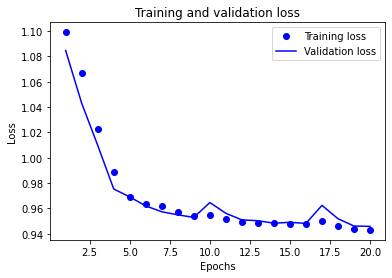

In [35]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

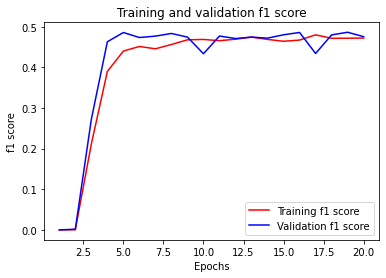

In [36]:
history_dict = history.history

loss_values = history_dict['f1_metric']
val_loss_values = history_dict['val_f1_metric']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'r', label='Training f1 score')
plt.plot(epochs, val_loss_values, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
plt.xlabel('Epochs')
plt.ylabel('f1 score')
plt.legend()

plt.show()

#### ROC-AUC curve

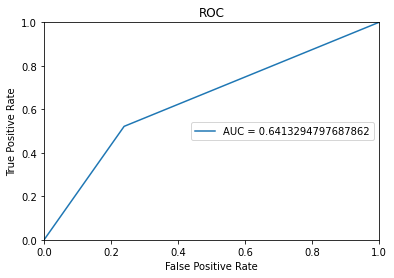

<Figure size 1080x720 with 0 Axes>

In [37]:
# Code taken from: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
# This code binarises the 3 class (Eg. Class 0 --> [0, 0, 0]; Class 1 --> [0, 1, 0], ...) and then graphs the roc.

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve

# Binarize data for getting AUC 
y_test_bin = label_binarize(y_test, classes=range(3)) 
y_pred_bin = label_binarize(y_pred, classes=range(3))

# Calculate FP , TP rate
fpr, tpr, threshold = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())

# Get AUC , 
auc = roc_auc_score(y_test_bin, y_pred_bin, average='micro', multi_class='ovr')
 
#create ROC curve
plt.plot(fpr,tpr , label= f"AUC = {auc}" , )
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0]) 
plt.title('ROC')
plt.legend(loc=7)
plt.figure(figsize = [15, 10])

plt.show()

In [39]:
set(y_pred)

{0, 1, 2}

Even though the evaluation metrics are poorer than the previous model, previously, the model predicted all the test instances to one class. The variation was not fetched by the model. Now, the predictions contain representative from all the classes.

Overall, if fine tuned more and experimented with deeper model architectures, this upsampled data could produce a better model than the ones with imbalanced data.

**References**

* https://stackoverflow.com/questions/50003595/earlystopping-is-ignoring-my-custom-metrics-defined-keras-model

* https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

* https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

* https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

* https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python